# Source injector

The "source injector" is a cosipy module that will generate mocked binned data based on the detector response and a source hypothesis (provided by the users). This should result in the same output as simulating the source using MEGAlib, but be much quicker. MEGAlib is only needed when the event-by-event data is required, or to create the detector response itself. 

The goal of this notebook is to get an idea how the source injector will work in practice. We need to take it from here to something that is user friendly and compatible with the rest of the modules.

First, let's load all dependecies:

In [4]:
# We'll use histpy's Histogram and mhealpy's HealpixMap as the basis
# develop cosipy. These object (or a derivative) will be passed around by 
# the different modules.
from histpy import Histogram
from mhealpy import HealpixMap

# Needed for coordinate conversion.
# cosipy uses astropy coordinates, with a custom
# SpacecraftFrame (coordinate frame attached to COSI)
from astropy.coordinates import SkyCoord
from cosipy.coordinates import SpacecraftFrame, Attitude

# cosipy uses astropy units
import astropy.units as u

#Other standard libraries
import numpy as np

import matplotlib.pyplot as plt

## Signal from a source

Here we obtain the expected number of counts for a given source hypothesis.

We need the detector response, which can convert from physical values --e.g. source position, spectrum-- to detected counts. For this tutorial we'll use the detector response for an idealized detector, called the "Compton sphere. The goals of this tutorial is not to get realistics simulations, but to understand the mechanics of of the code.. The response can be found in the sftp server at `/uploads/cosipy/test_data/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip` (remember to unzip it). 

In [6]:
response_path = "/Users/eneights/work/COSI/data_challenge_2/intro_cosipy/test_data/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5"

from cosipy.response import FullDetectorResponse

response = FullDetectorResponse.open(response_path)

These is the source hypothesis. Let's inject a GRB-like event, lasting only 1s

In [7]:
duration = 1*u.s

# The attitude defines the rotation of the spacecraft with respect
# to the inertial ICRS frame. During flight this information will come from the
# spacecraft telemetry data, but for now let's assume the spacecraft is aligned with the ICRS.
coord = SkyCoord(ra = 20*u.deg, dec = 40*u.deg, 
                 frame = 'icrs', 
                 attitude = Attitude.identity())

The detector response contains the response as a function of the incoming direction in the spacecraft coordinates. As the spacecraft (SC) rotates, the fixed sky location (RA, Dec) of a given source will move in SC coordinate system, and we need to integrate all locations weighted by the time spent in that direction. These is encoded in the "dwell time map", which will be produced by the "spacecraft orientation" cosipy module, based on the telemetry information. For our case though, we can assume the GRB occurred at a fixed location because the duration is very short. 

Side note: at some point I was incorrectly calling the "dwell time map" a "exposure map", which might be confusing.

In [8]:
# The dwell time map has the same pixelation (base) as the detector response.
# We start with an empty map
dwell_time_map = HealpixMap(base = response, 
                            unit = u.s, 
                            coordsys = SpacecraftFrame())

# Here we add duration of the GRB, at the location where it happend (in spacecraft coordinates)
# We use interpolation to get a better result
pixels, weights = dwell_time_map.get_interp_weights(coord)

for p,w in zip(pixels, weights):
    dwell_time_map[p] += w*duration
    
# Without interpolating, it would look like these. Give it a try.
# pixel = dwell_time_map.ang2pix(coord)
# dwell_time_map[pixel] += duration

This is how the dwell time map looks. The red dot shows the exact location of the GRB.

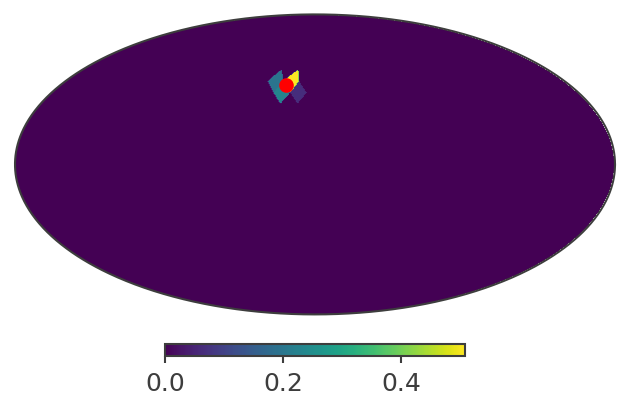

In [9]:
_,ax = dwell_time_map.plot(coord = SpacecraftFrame(attitude = Attitude.identity()));

ax.scatter(coord.ra, coord.dec, transform=ax.get_transform('world'), color = 'red')

The sum of all pixel in the dwell time map is simply the duration of the data that was integrated. In this case is just the duration of the GRB.

In [10]:
sum(dwell_time_map)

<Quantity 1. s>

The detector response is then convolved with the dwell time map to get the point source response:

In [11]:
psr = response.get_point_source_response(dwell_time_map)

The point source response is still quite generic. We obtained the response for a give location and duration, but we still convolved this with a given spectral assumption:

In [12]:
from threeML import *
from astropy.units import Quantity

# This is not a very realistic spectrum, but help to illustrate the method.
# You can play with other parameters. 
spectrum = Powerlaw()
index = -1.7
piv = 1 * u.keV
K = 1e-1 / u.cm / u.cm / u.s / u.keV
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit
    
# We project into the only event parameters that we can measure in COSI
signal = psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])

The result `signal` is histogram that contains the expected counts in measured energy (`Em`) and the "Compton Data Space": Compton scatter angle (`Phi`) and direction (in SC coordinates) of the scattered photon in he (`PsiChi`). For reference, see the following figure from [this](https://arxiv.org/abs/2102.13158) paper. The only different is that here we are using spacecraft coordinate instead of galactic coordinates. ![](cds.png)

The `signal` object is a 3D histogram. Note that the last axis, `PsiChi`, is actually a 2D axis encoding the coordinates in a sphere as pixels in a HEALPix grid. So, in a sense, it's really a 4D histogram.

In [13]:
type(signal)

histpy.histogram.Histogram

In [14]:
signal.ndim

3

In [15]:
signal.axes.labels

array(['Em', 'Phi', 'PsiChi'], dtype='<U6')

Let's explore this simulated signal and see how it looks.

First, we can get the measured energy distribution by projecting the histogram into the `Em`:

(<AxesSubplot: xlabel='Em [keV]'>, <ErrorbarContainer object of 3 artists>)

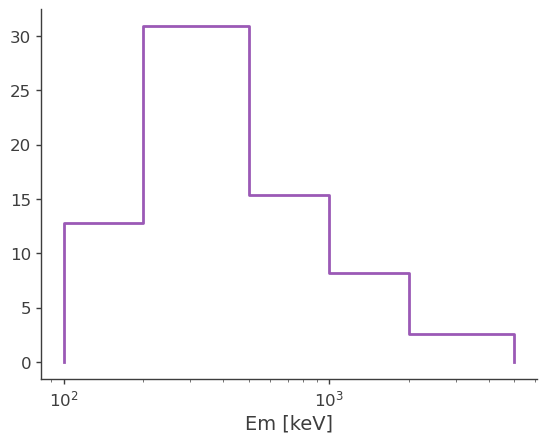

In [16]:
signal.project('Em').plot()

This shape is a combination of the spectrum, the energy resolution, and the effective area of the detector as a function of energy.

We can get the total number of events we expect from the GRB by summing over all bins:

In [17]:
np.sum(signal)

69.81483813523818

Now let's explore the CDS. It's easier to visualize if we take slices in energy and scatter angle. For reference, these are the bin edges:

In [18]:
signal.axes['Em'].edges

<Quantity [ 100.,  200.,  500., 1000., 2000., 5000.] keV>

In [19]:
signal.axes['Phi'].edges

<Quantity [  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,
           100., 110., 120., 130., 140., 150., 160., 170., 180.] deg>

This is the plot of the distribution of events within the energy range 1-2 MeV (bin 3) and scattered angles between 40-50deg (bin 4):

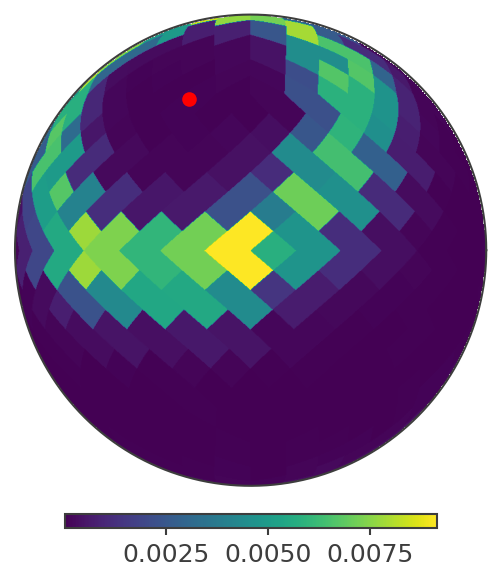

In [20]:
#Since `PsiChi` is encoded as pixel in a HEALPix grid, we need mhealpy to render it back to a sphere
m_signal = HealpixMap(signal.slice[{'Em':3, 'Phi':4}].project('PsiChi').todense().contents,
                      coordsys = SpacecraftFrame())

fig = plt.figure(dpi = 150)

# Try also other projections, e.g. projection = 'mollview'
ax = fig.add_subplot(projection = 'orthview')

m_signal.plot(ax, coord = SpacecraftFrame(attitude = Attitude.identity()))

# Location of the source
ax.scatter(coord.ra, coord.dec, transform=ax.get_transform('world'), color = 'red')

This is a horizontal slice of the Compton cone shown in the figure above, spread by detector effects and the finite size of the `Em` and `Phi` bins. Try selecting different `Phi` bins to see how these circle grows or shrinks, and relate that to the CDS figure.

You can also try selecting different energy bins. The opening of the cone in the CDS is geometrically constrained and does not depend on the energy. This circle becomes more blurry at different energies though, which is related to the energy resolution and the bin width.

## Getting a fake background

The background from Compton telescopes can be complex, and in general we need to either simulate all the different components with MEGAlib and/or use real data to constrain it. For the purpose of having a toy background that we can use to develop our algorithms, let's use the detector response to simulate an (unrealistic) isotropic gamma-ray background. The final source injector should use a background model as input instead.

We'll repurpose the point source convolution by generating an effective dwell time map with the same value for all pixels. Since all pixels have the same area, this is simulating an isotropic distribution

In [21]:
iso_map = HealpixMap(base = response, 
                     unit = u.s, 
                     coordsys = SpacecraftFrame())

# Filling all pixels with a constant. The actual value doesn't
# since we will renormalize it
iso_map[:] = 1*u.s

In [22]:
# Non-realistic spectrum
bkg_spectrum = Powerlaw()
bkg_index = -2
bkg_piv = 1 * u.keV
bkg_K = 1 / u.cm / u.cm / u.s / u.keV
bkg_spectrum.index.value = bkg_index
bkg_spectrum.K.value = bkg_K.value
bkg_spectrum.piv.value = bkg_piv.value
bkg_spectrum.K.unit = bkg_K.unit
bkg_spectrum.piv.unit = bkg_piv.unit
    
iso_response = response.get_point_source_response(iso_map)
    
bkg = iso_response.get_expectation(bkg_spectrum).project(['Em', 'Phi', 'PsiChi'])

Now, let's renormalize the background to a total rate of 1k Hz. This is again not realistic, but was chosen such that the signal will show up clearly enough above the background and we can work on the algorihtms.

In [23]:
np.sum(bkg)

90238.31928090738

In [24]:
bkg = bkg * 1e3 / np.sum(bkg)

In [25]:
np.sum(bkg)

1000.0

These are the same plots as we did for the signal, so you can compare:

(<AxesSubplot: xlabel='Em [keV]'>, <ErrorbarContainer object of 3 artists>)

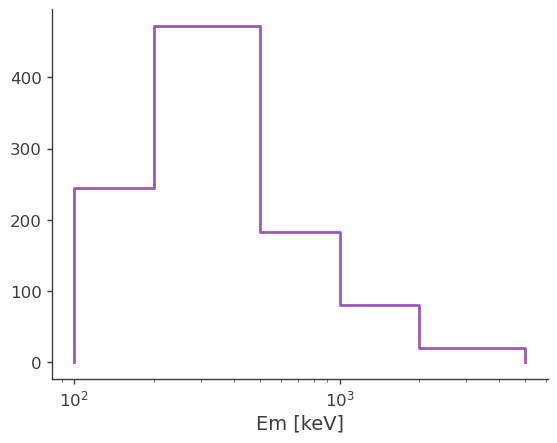

In [26]:
bkg.project('Em').plot()

(<matplotlib.image.AxesImage at 0x28ff563a0>, <OrthviewSubplot: >)

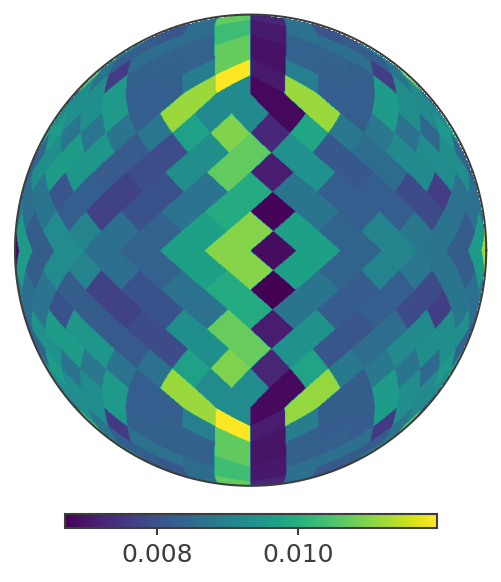

In [27]:
m_bkg = HealpixMap(bkg.slice[{'Em':3, 'Phi':4}].project('PsiChi').todense().contents)

fig = plt.figure(dpi = 150)

ax = fig.add_subplot(projection = 'orthview')

m_bkg.plot(ax)

Note: I actually don't understand what causes the strip in the middle. Maybe it's a beating pattern caused by converting from FISBEL to HEALPix during the creation of the detector response. I plan to generate a detector response using HEALPix directly, and will revisit this then.

## Putting it togetter

Once we obtain the expected signal, it's easy to add it do the background to simulate how the observed data would look like

In [28]:
data = signal + bkg

If the user wants to simulate multiple sources, just add those to this sum.

This is how it looks:

(<matplotlib.image.AxesImage at 0x299cf4d60>, <OrthviewSubplot: >)

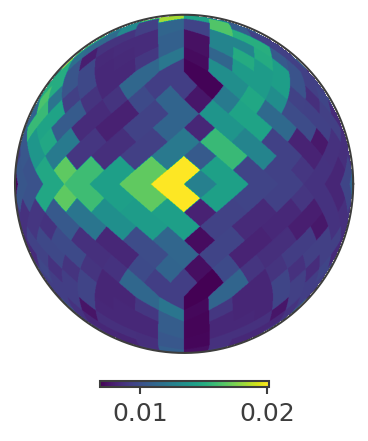

In [29]:
m_data = HealpixMap(data.slice[{'Em':3, 'Phi':4}].project('PsiChi').todense().contents)

fig = plt.figure(dpi = 150)

ax = fig.add_subplot(1,2,1, projection = 'orthview')

m_data.plot(ax)

The final source injector should save the result to disk in the same format as the "Data classes" module, including all the appropiate header information. However, for now you can use directly histpy's `write` method:

In [30]:
data.write("data.h5")
bkg.write("bkg.h5")
signal.write("signal.h5")

To load them back, use:

In [31]:
data = Histogram.open("data.h5")
bkg = Histogram.open("bkg.h5")
signal = Histogram.open("signal.h5")